In [ ]:
from google.colab import files
import pandas as pd

uploaded_files = files.upload()

ulds_file = 'ulds.csv'
packages_file = 'packages_new.csv'

if ulds_file in uploaded_files and packages_file in uploaded_files:
    ulds_data = pd.read_csv(ulds_file)
    packages_data = pd.read_csv(packages_file)

    print("\nFiltered ULDs Data:")
    print(ulds_data.head())

    print("\nFiltered Packages Data:")
    print(packages_data.head())
else:
    print("Error: Please ensure both 'ulds.csv' and 'packages_new.csv' are uploaded.")

Saving packages_new.csv to packages_new.csv
Saving ulds.csv to ulds.csv

Filtered ULDs Data:
   container_id  Length (cm)  Width (cm)  Height (cm)  Weight Limit (kg)
0             1          224         318          162               2500
1             2          224         318          162               2500
2             3          244         318          244               2800
3             4          244         318          244               2800
4             5          244         318          285               3500

Filtered Packages Data:
  Package Identifier  Length (cm)  Width (cm)  Height (cm)  Weight (kg)  \
0                P-1         99.0        53.0         55.0         61.0   
1                P-2         56.0        99.0         81.0         53.0   
2                P-3         42.0       101.0         51.0         17.0   
3                P-4        108.0        75.0         56.0         73.0   
4                P-5         88.0        58.0         64.0         93

<ipython-input-2-e2f5fa363410>:11: DtypeWarning: Columns (0,5) have mixed types. Specify dtype option on import or set low_memory=False.
  packages_data = pd.read_csv(packages_file)


In [ ]:
packages_data = packages_data.iloc[:200]

In [ ]:
print(packages_data.dtypes)

Package Identifier     object
Length (cm)           float64
Width (cm)            float64
Height (cm)           float64
Weight (kg)           float64
Type (P/E)             object
Cost of Delay         float64
dtype: object


In [ ]:
total_true = (packages_data['Type (P/E)'] == True).sum()
print(total_true)
print(len(packages_data))

54
200


In [ ]:
import heapq

## TODO: 1.Pushing mechanism 2.Recalc of pivots 3.Placement of other boxes.

class Box:
    def __init__(self, identifier, length, width, height, weight, cost,type_):
        self.identifier = identifier
        self.length = length
        self.width = width
        self.height = height
        self.weight = weight
        self.type_ = type_
        self.cost=cost
        self.packed=False
        self.volume = length * width * height

    def orientations(self):
        return [
            (self.length, self.width, self.height),
            (self.length, self.height, self.width),
            (self.width, self.length, self.height),
            (self.width, self.height, self.length),
            (self.height, self.length, self.width),
            (self.height, self.width, self.length),
        ]


class Container:
    def __init__(self, length, width, height, max_weight):
        self.length = length
        self.width = width
        self.height = height
        self.max_weight = max_weight
        self.remaining_weight = max_weight
        self.packed_boxes = []
        self.pivot_points = [
            (0, 0, 0),
            (self.length, 0, 0),
            (0, self.width, 0),
            (self.length, self.width, 0)
        ]
        self.volume_utilization = 0.0

    def calculate_center_of_mass(self):
        """
        Calculate the center of mass of the container based on the positions and weights of the packed boxes.
        The center of mass is the weighted average of the positions of all boxes.
        """
        total_weight = self.max_weight-self.remaining_weight

        if total_weight == 0:
            return (0, 0, 0)

        weighted_positions = np.array([np.array(packed["position"]) * packed["box"].weight for packed in self.packed_boxes])
        center_of_mass = weighted_positions.sum(axis=0) / total_weight

        return tuple(center_of_mass)

    def calculate_volume_utilization(self) -> float:
        """Calculate the volume utilization of the container."""
        packed_volume = sum(
            box['box'].length * box['box'].width * box['box'].height
            for box in self.packed_boxes
        )
        total_volume = self.length * self.width * self.height
        self.volume_utilization = packed_volume / total_volume
        return self.volume_utilization

    def can_place(self, box_dims, pivot):
        bx, by, bz = box_dims
        px, py, pz = pivot
        return (
            px + bx <= self.length and
            py + by <= self.width and
            pz + bz <= self.height
        )
    def is_supported(self, box_dims, pivot):
      bx, by, bz = box_dims
      px, py, pz = pivot

      # Check if the box is on the ground (z = 0)
      if pz == 0:
          return True

      # Check if the box is at least partially supported by other boxes
      for packed in self.packed_boxes:
          packed_pos = packed["position"]
          packed_orientation = packed["orientation"]
          packed_bx, packed_by, packed_bz = packed_orientation

          x_overlap = max(0, min(px + bx, packed_pos[0] + packed_bx) - max(px, packed_pos[0]))
          y_overlap = max(0, min(py + by, packed_pos[1] + packed_by) - max(py, packed_pos[1]))

          if x_overlap > 0 and y_overlap > 0 and pz == packed_pos[2] + packed_bz:
              return True

      return False

    def is_overlapping(self, box_dims, pivot):
        bx, by, bz = box_dims
        px, py, pz = pivot
        for packed in self.packed_boxes:
            packed_pos = packed["position"]
            packed_orientation = packed["orientation"]
            packed_bx, packed_by, packed_bz = packed_orientation
            if not (px + bx <= packed_pos[0] or px >= packed_pos[0] + packed_bx or
                    py + by <= packed_pos[1] or py >= packed_pos[1] + packed_by or
                    pz + bz <= packed_pos[2] or pz >= packed_pos[2] + packed_bz):
                return True
        return False

    def calc_stable(self, box_dims, pivot):
      bx, by, bz = box_dims
      px, py, pz = pivot
      base_area = bx * by
      total_support_area = 0
      support_points = []

      if pz == 0:
          return base_area

      for packed in self.packed_boxes:
          packed_pos = packed["position"]
          packed_orientation = packed["orientation"]
          packed_bx, packed_by, packed_bz = packed_orientation

          x_overlap = max(0, min(px + bx, packed_pos[0] + packed_bx) - max(px, packed_pos[0]))
          y_overlap = max(0, min(py + by, packed_pos[1] + packed_by) - max(py, packed_pos[1]))

          if (x_overlap > 0 and y_overlap > 0 and
              packed_pos[2] + packed_bz == pz):
              support_area = x_overlap * y_overlap
              total_support_area += support_area
              support_points.append({
                  'position': packed_pos,
                  'orientation': packed_orientation,
                  'support_area': support_area
              })


      if support_points:
          total_x = sum((point['position'][0] + point['orientation'][0]/2) * point['support_area'] for point in support_points)
          total_y = sum((point['position'][1] + point['orientation'][1]/2) * point['support_area'] for point in support_points)

          support_center_x = total_x / total_support_area
          support_center_y = total_y / total_support_area

          if (px <= support_center_x < px + bx and
              py <= support_center_y < py + by):
              return total_support_area

      return total_support_area


    def place_box(self, box, pivot, orientation):
        bx, by, bz = orientation
        px, py, pz = pivot
        if (not self.can_place((bx, by, bz), pivot) or
        self.is_overlapping((bx, by, bz), pivot) or
        not self.is_supported((bx, by, bz), pivot) or self.remaining_weight < box.weight):
          return False

        self.packed_boxes.append({
          "box": box,
          "position": (px, py, pz),
          "orientation": orientation,
        })
        box.packed = True

        self.remaining_weight -= box.weight
        self.generate_pivots(px, py, pz, bx, by, bz)
        self.calculate_volume_utilization()
        return True

    def generate_pivots(self, px, py, pz, bx, by, bz):
        new_pivots = [
            (px + bx, py, pz),
            (px, py + by, pz),
            (px, py, pz + bz),
        ]

        valid_pivots = []
        for pivot in new_pivots:
            px, py, pz = pivot
            is_surface_found = False

            while pz > 0:
                if any(
                    (other["position"][0] <= px < other["position"][0] + other["orientation"][0]) and
                    (other["position"][1] <= py < other["position"][1] + other["orientation"][1]) and
                    (other["position"][2] + other["orientation"][2] == pz)
                    for other in self.packed_boxes
                ):
                    is_surface_found = True
                    break
                pz -= 1

            if pz == 0:
              is_surface_found = True

            if is_surface_found:
                valid_pivots.append((px, py, pz))
        self.pivot_points.extend(valid_pivots)
        self.pivot_points = list(set(self.pivot_points))
        self.sort_pivots()

    def sort_pivots(self):
        self.pivot_points.sort(key=lambda p: (p[2], p[1], p[0]))

    def evaluate_pivot(self, box):
      best_score = float('-inf')
      best_orientation = None
      best_pivot = None

      for pivot in self.pivot_points:
          for orientation in box.orientations():
              bx, by, bz = orientation
              px, py, pz = pivot

              if not self.can_place((bx, by, bz), pivot) or self.is_overlapping((bx, by, bz), pivot):
                  continue

              vertical_score = -(pz/self.height)
              edge_proximity_score = (
                  (self.length - (px + bx)) +
                  (self.width - (py + by)) +
                  (self.height - (pz + bz))
              )
              edge_proximity_score/=(self.length + self.width + self.height)
              support_area = self.calc_stable((bx, by, bz), pivot)
              stability_score = support_area / (bx * by)
              total_score = (
                  0.4 * edge_proximity_score +
                  0.3 * vertical_score +
                  0.3 * stability_score
              )

              if total_score > best_score:
                  best_score = total_score
                  best_orientation = orientation
                  best_pivot = pivot

      return best_pivot, best_orientation


    def calculate_structural_physical_stability(self):
      bsa = sum(box["orientation"][0] * box["orientation"][1] for box in self.packed_boxes)

      cgh = self.calculate_center_of_mass()[2]
      sf = self.calculate_stacking_factor() if self.calculate_stacking_factor() is not None else 0

      alpha1 = 0.25
      alpha2 = 0.25
      alpha3 = 0.50

      stability = alpha1 * bsa + alpha2 * (1 - cgh) + alpha3 * (1 - sf)
      return stability


    def calculate_stacking_factor(self):
      """
      Calculate the stacking factor for all boxes in the container.
      Stacking factor is the ratio of the weight of all boxes above
      (sharing XY overlap and higher Z) to the weight of the current box.
      """
      for packed_box in self.packed_boxes:
          box = packed_box["box"]
          x1, y1, z1 = packed_box["position"]
          length1, width1, height1 = packed_box["orientation"]

          total_num = 0

          for other_packed_box in self.packed_boxes:
              if other_packed_box == packed_box:
                  continue

              other_box = other_packed_box["box"]
              x2, y2, z2 = other_packed_box["position"]
              length2, width2, height2 = other_packed_box["orientation"]

              x_overlap = (x1 < x2 + length2) and (x2 < x1 + length1)
              y_overlap = (y1 < y2 + width2) and (y2 < y1 + width1)

              if x_overlap and y_overlap and z2 > z1:
                  total_num += 1

          stacking_factor = total_num / box.weight if box.weight > 0 else 0




In [ ]:
def dynamic_volume_based_packing(boxes, containers):
    opened_containers_queue = []
    unopened_containers = containers.copy()

    # Separate 'P' and 'E' boxes
    p_boxes = [box for box in boxes if box.type_ == True]
    e_boxes = [box for box in boxes if box.type_ == False]


    for box in p_boxes:

        packed = False

        opened_containers_queue.sort(key=lambda x: (-len(x[2].packed_boxes), x[2].remaining_weight))

        for i, (_, _, container, pivot) in enumerate(opened_containers_queue):
            best_pivot, best_orientation = container.evaluate_pivot(box)
            if best_pivot and container.place_box(box, best_pivot, best_orientation):
                packed = True
                opened_containers_queue.pop(i)
                heapq.heappush(opened_containers_queue, (-len(container.packed_boxes), id(container), container, best_pivot))
                break


        if not packed:
            for container in unopened_containers:
                best_pivot, best_orientation = container.evaluate_pivot(box)
                if best_pivot and container.place_box(box, best_pivot, best_orientation):
                    unopened_containers.append(container)
                    packed = True
                    heapq.heappush(opened_containers_queue, (-len(container.packed_boxes), id(container), container, best_pivot))
                    break


    #  More rem. weight are prioritized first
    opened_containers_queue = []
    for container in containers:
        for pivot in container.pivot_points:
            heapq.heappush(opened_containers_queue, (-container.remaining_weight, id(container), container, pivot))

    for box in e_boxes:

        packed = False

        for _ in range(len(opened_containers_queue)):
            _, _, container, pivot = heapq.heappop(opened_containers_queue)
            best_pivot, best_orientation = container.evaluate_pivot(box)

            if best_pivot and container.place_box(box, best_pivot, best_orientation):
                packed = True
                heapq.heappush(opened_containers_queue, (-container.remaining_weight, id(container), container, best_pivot))
                break


    return containers

In [ ]:
import numpy as np
import random
from typing import List, Dict, Union


class ThreeDimensionalBinPacking:
      def __init__(self,
                  bins: List[Dict[str, Union[int, float]]],
                  packages: List[Dict[str, Union[str, float]]],
                  pop_size: int = 100,
                  generations: int = 100,
                  elitism: int = 10,
                  tournament_prob: float = 0.85,
                  crossover_prob: float = 0.75,
                  mutation_prob: float = 0.01):

          self.bins = bins
          self.packages = packages
          self.pop_size = pop_size
          self.generations = generations
          self.elitism = elitism
          self.tournament_prob = tournament_prob
          self.crossover_prob = crossover_prob
          self.mutation_prob = mutation_prob

          self.population = self._initialize_population()

      def _initialize_population(self) -> List[Dict[str, List[int]]]:
          """
          Initialize the population with special chromosomes and random individuals.

          :return: List of chromosomes.
          """
          population = []

          for sort_criteria in [
              lambda idx: self.packages[idx]['cost'] / (
                  self.packages[idx]['length'] *
                  self.packages[idx]['width'] *
                  self.packages[idx]['height']
              ),
              lambda idx: self.packages[idx]['length'] * self.packages[idx]['width']
          ]:
              box_sequence = sorted(range(len(self.packages)), key=sort_criteria, reverse=True)
              container_sequence = list(range(len(self.bins)))
              random.shuffle(container_sequence)

              population.append({
                  'box_sequence': box_sequence,
                  'container_sequence': container_sequence
              })

          # Add random chromosomes
          while len(population) < self.pop_size:
              population.append({
                  'box_sequence': random.sample(range(len(self.packages)), len(self.packages)),
                  'container_sequence': random.sample(range(len(self.bins)), len(self.bins))
              })

          return population

      def _calculate_fitness(self, containers):
          if not containers:
              return 0

          total_volume_placed = sum(
              sum(packed["box"].volume for packed in container.packed_boxes)
              for container in containers
          )
          total_container_volume = sum(
              container.length * container.width * container.height for container in containers
          )

          bins_with_true_type = sum(
              1 for container in containers if any(packed["box"].type_ == "True" for packed in container.packed_boxes)
          )

          packages_placed = sum(len(container.packed_boxes) for container in containers)
          packages_placed_ratio = packages_placed / len(self.packages) if self.packages else 0

          space_utilization = (
              total_volume_placed / total_container_volume if total_container_volume > 0 else 0
          )

          total_cost_packed = sum(
              packed["box"].cost for container in containers for packed in container.packed_boxes
          )
          total_possible_cost = sum(box["cost"] for box in self.packages)

          structural_physical_stability = sum(
              container.calculate_structural_physical_stability() for container in containers
          )

          fitness = (
              space_utilization * 0.2 +
              (1 / bins_with_true_type if bins_with_true_type > 0 else 0) * 0.3 +
              (total_cost_packed / total_possible_cost if total_possible_cost > 0 else 0) * 0.3 +
              structural_physical_stability * 0.2
          )

          return max(0, fitness)
      def _tournament_selection(self) -> List[Dict[str, List[int]]]:
        population_with_fitness = []

        for chromosome in self.population:
            BPS = [Box(**self.packages[idx]) for idx in chromosome['box_sequence']]
            CLS = [Container(**self.bins[idx]) for idx in chromosome['container_sequence']]

            packed_solution = dynamic_volume_based_packing(BPS, CLS)

            if packed_solution is not None:
                fitness = self._calculate_fitness(packed_solution)
            else:
                fitness = float('-inf')

            population_with_fitness.append((chromosome, fitness))

        population_with_fitness.sort(key=lambda x: x[1], reverse=True)

        mating_pool = [item[0] for item in population_with_fitness[:self.elitism]]

        while len(mating_pool) < self.pop_size:
            idx1, idx2 = random.sample(range(len(population_with_fitness)), 2)
            chrom1, fit1 = population_with_fitness[idx1]
            chrom2, fit2 = population_with_fitness[idx2]

            if random.random() < self.tournament_prob:
                selected = chrom1 if fit1 > fit2 else chrom2
            else:
                selected = chrom1 if fit1 < fit2 else chrom2

            mating_pool.append(selected)

        return mating_pool

      def _crossover(self, parent1: Dict[str, List[int]], parent2: Dict[str, List[int]]) -> Dict[str, List[int]]:
          """
          Enhanced Order crossover to prioritize high-cost boxes.
          """
          i, j = sorted(random.sample(range(len(self.packages)), 2))

          box_offspring = [None] * len(self.packages)
          box_offspring[i:j+1] = parent1['box_sequence'][i:j+1]

          remaining_boxes = [box for box in parent2['box_sequence'] if box not in box_offspring[i:j+1]]
          remaining_boxes = sorted(remaining_boxes, key=lambda idx: self.packages[idx]['cost'], reverse=True)

          box_remaining_idx = 0
          for k in range(len(self.packages)):
              if box_offspring[k] is None:
                  box_offspring[k] = remaining_boxes[box_remaining_idx]
                  box_remaining_idx += 1

          container_offspring = [None] * len(self.bins)
          container_offspring[i:j+1] = parent1['container_sequence'][i:j+1]

          remaining_containers = [cont for cont in parent2['container_sequence'] if cont not in container_offspring[i:j+1]]
          random.shuffle(remaining_containers)

          container_remaining_idx = 0
          for k in range(len(self.bins)):
              if container_offspring[k] is None:
                  container_offspring[k] = remaining_containers[container_remaining_idx]
                  container_remaining_idx += 1

          return {
              'box_sequence': box_offspring,
              'container_sequence': container_offspring
          }


      def _mutation(self, chromosome: Dict[str, List[int]]) -> Dict[str, List[int]]:
        """
        Enhanced mutation to prioritize high-cost boxes and explore diverse arrangements.
        """
        if random.random() < self.mutation_prob:
            idx1, idx2 = random.sample(range(len(self.packages)), 2)
            # Prefer swapping boxes with higher costs
            if self.packages[chromosome['box_sequence'][idx1]]['cost'] > self.packages[chromosome['box_sequence'][idx2]]['cost']:
                idx1, idx2 = idx2, idx1
            chromosome['box_sequence'][idx1], chromosome['box_sequence'][idx2] = \
                chromosome['box_sequence'][idx2], chromosome['box_sequence'][idx1]

        if random.random() < self.mutation_prob:
            idx1, idx2 = random.sample(range(len(self.bins)), 2)
            chromosome['container_sequence'][idx1], chromosome['container_sequence'][idx2] = \
                chromosome['container_sequence'][idx2], chromosome['container_sequence'][idx1]

        return chromosome

      def run_genetic_algorithm(self):
        """
        Run the genetic algorithm to find the best packing solution

        :return: Best packing solution and its fitness
        """
        best_fitness = 0
        best_solution = None

        for generation in range(self.generations):
            mating_pool = self._tournament_selection()

            new_population = []

            while len(new_population) < self.pop_size:
                if random.random() < self.crossover_prob:
                    parent1, parent2 = random.sample(mating_pool, 2)
                    offspring = self._crossover(parent1, parent2)

                else:
                    offspring = random.choice(mating_pool)

                offspring = self._mutation(offspring)

                new_population.append(offspring)

            self.population = new_population
            for chromosome in self.population:
                BPS = [Box(**self.packages[idx]) for idx in chromosome['box_sequence']]
                CLS = [Container(**self.bins[idx]) for idx in chromosome['container_sequence']]

                packed_solution = dynamic_volume_based_packing(BPS, CLS)
                if packed_solution is not None:
                    fitness = self._calculate_fitness(packed_solution)

                    if fitness > best_fitness:
                        best_fitness = fitness
                        best_solution = packed_solution

        return best_solution, best_fitness


In [ ]:

bins = ulds_data.apply(
    lambda x: {
        'length': x['Length (cm)'],
        'width': x['Width (cm)'],
        'height': x['Height (cm)'],
        'max_weight': x['Weight Limit (kg)']
    },
    axis=1
).tolist()

packages = packages_data.apply(
    lambda x: {
        'identifier': x['Package Identifier'],
        'length': x['Length (cm)'],
        'width': x['Width (cm)'],
        'height': x['Height (cm)'],
        'weight': x['Weight (kg)'],
        'type_': x['Type (P/E)'],
        'cost': x['Cost of Delay']
    },
    axis=1
).tolist()



print("\nFormatted Bins Data:")
print(bins)


print("\nFormatted Packages Data:")
print(packages)


genetic_packer = ThreeDimensionalBinPacking(
    bins=bins,
    packages=packages,
    pop_size=30,
    generations=30,
)


best_solution, best_fitness = genetic_packer.run_genetic_algorithm()
print(best_fitness)



Formatted Bins Data:
[{'length': 224, 'width': 318, 'height': 162, 'max_weight': 2500}, {'length': 224, 'width': 318, 'height': 162, 'max_weight': 2500}, {'length': 244, 'width': 318, 'height': 244, 'max_weight': 2800}, {'length': 244, 'width': 318, 'height': 244, 'max_weight': 2800}, {'length': 244, 'width': 318, 'height': 285, 'max_weight': 3500}, {'length': 244, 'width': 318, 'height': 285, 'max_weight': 3500}]

Formatted Packages Data:
[{'identifier': 'P-1', 'length': 99.0, 'width': 53.0, 'height': 55.0, 'weight': 61.0, 'type_': False, 'cost': 176.0}, {'identifier': 'P-2', 'length': 56.0, 'width': 99.0, 'height': 81.0, 'weight': 53.0, 'type_': True, 'cost': 0.0}, {'identifier': 'P-3', 'length': 42.0, 'width': 101.0, 'height': 51.0, 'weight': 17.0, 'type_': True, 'cost': 0.0}, {'identifier': 'P-4', 'length': 108.0, 'width': 75.0, 'height': 56.0, 'weight': 73.0, 'type_': False, 'cost': 138.0}, {'identifier': 'P-5', 'length': 88.0, 'width': 58.0, 'height': 64.0, 'weight': 93.0, 'type

In [ ]:
total_priority_packages = sum(1 for package in packages if package['type_'] == True)

packed_priority_packages = sum(
    1 for package in packages if package['type_'] == True and any(
        packed["box"].identifier == package['identifier']
        for container in best_solution
        for packed in container.packed_boxes
    )
)

print(f"Total Priority Packages: {total_priority_packages}")
print(f"Priority Packages Packed: {packed_priority_packages}")

unpacked_priority_packages = total_priority_packages - packed_priority_packages
print(f"Priority Packages Unpacked: {unpacked_priority_packages}")


Total Priority Packages: 54
Priority Packages Packed: 54
Priority Packages Unpacked: 0


In [ ]:
num_boxes_packed = sum(len(container.packed_boxes) for container in best_solution)

total_cost_packed = sum(
    packed["box"].cost for container in best_solution for packed in container.packed_boxes
)

num_containers_with_priority = sum(
    1 for container in best_solution if any(
        packed["box"].type_ == True for packed in container.packed_boxes
    )
)

total_cost_all_boxes = sum(box['cost'] for box in packages)

k = 5000
total_cost = total_cost_all_boxes - total_cost_packed + num_containers_with_priority * k

print("Total Cost Packed:", total_cost_packed)
print("Total Cost of All Boxes:", total_cost_all_boxes)
print("Number of Boxes Packed:", num_boxes_packed)
print("Best Fitness:", best_fitness)
print("Total Cost (Including Penalty):", total_cost)

Total Cost Packed: 10528.0
Total Cost of All Boxes: 14457.0
Number of Boxes Packed: 160
Best Fitness: 40864.12472655049
Total Cost (Including Penalty): 18929.0


In [ ]:
def validate_solution(best_solution):
    """
    Validates the best_solution for:
    1. No intersections between boxes in a container.
    2. All boxes are within the container boundaries.
    3. Total weight of boxes does not exceed the container's max weight.
    4. Each box is placed on the ground or partially supported by another box, ensuring
       that part of its base rests on another box's top.
    5. A box is not packed in multiple containers.

    Args:
    - best_solution (list of Container): The solution, where each container contains packed_boxes
      with box objects, positions, and orientations.

    Returns:
    - bool: True if the solution is valid, False otherwise.
    - str: Message indicating the validation result.
    """
    packed_boxes_identifiers = set()

    for (cont_idx, container) in enumerate(best_solution):
        total_weight = 0

        # Check for weight constraint
        for packed_box in container.packed_boxes:
            box = packed_box["box"]
            total_weight += box.weight

            if total_weight > container.max_weight:
                return False, f"Container weight exceeded. Current weight {total_weight} exceeds max weight {container.max_weight}"

        # Check for boundary violations
        for idx, packed_box in enumerate(container.packed_boxes):
            box = packed_box["box"]
            x, y, z = packed_box["position"]
            length, width, height = packed_box["orientation"]

            # Check container boundary constraints
            if (x + length > container.length or
                y + width > container.width or
                z + height > container.height):
                return False, f"Box {box.identifier} with dimensions {length}x{width}x{height} exceeds container boundaries"

        # Check for intersection between boxes
        for i, packed_box1 in enumerate(container.packed_boxes):
            box1 = packed_box1["box"]
            x1, y1, z1 = packed_box1["position"]
            l1, w1, h1 = packed_box1["orientation"]

            for j, packed_box2 in enumerate(container.packed_boxes):
                if i != j:
                    box2 = packed_box2["box"]
                    x2, y2, z2 = packed_box2["position"]
                    l2, w2, h2 = packed_box2["orientation"]

                    if (x1 < x2 + l2 and x1 + l1 > x2 and
                        y1 < y2 + w2 and y1 + w1 > y2 and
                        z1 < z2 + h2 and z1 + h1 > z2):
                        return False, f"Boxes {box1.identifier} and {box2.identifier} at positions {packed_box1['position']} and {packed_box2['position']} intersect"

        for idx, packed_box in enumerate(container.packed_boxes):
            box = packed_box["box"]
            x, y, z = packed_box["position"]
            length, width, height = packed_box["orientation"]

            if z > 0:
                is_supported = False
                for other_idx, other_packed_box in enumerate(container.packed_boxes):
                    if idx != other_idx:
                        other_x, other_y, other_z = other_packed_box["position"]
                        ol, ow, oh = other_packed_box["orientation"]

                        # Check if the current box is directly on top of another box
                        if other_z + oh == z:
                            # Check for overlap in x and y dimensions
                            x_overlap = max(0, min(x + length, other_x + ol) - max(x, other_x))
                            y_overlap = max(0, min(y + width, other_y + ow) - max(y, other_y))

                            # Check if there is any overlap at all
                            if x_overlap > 0 or y_overlap > 0:
                                is_supported = True
                                break

                if not is_supported:
                    return False, f"Box {box.identifier} of container {cont_idx} at position {(x, y, z)} does not have its base adequately supported"

            if box.identifier in packed_boxes_identifiers:
                return False, f"Box {box.identifier} is packed in multiple containers"
            else:
                packed_boxes_identifiers.add(box.identifier)

    return True, "Solution is valid."
validate_solution(best_solution)

(True, 'Solution is valid.')

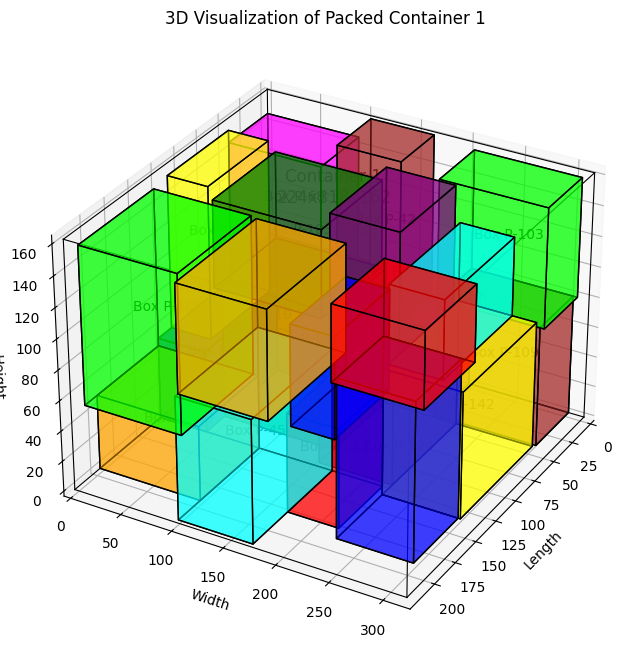

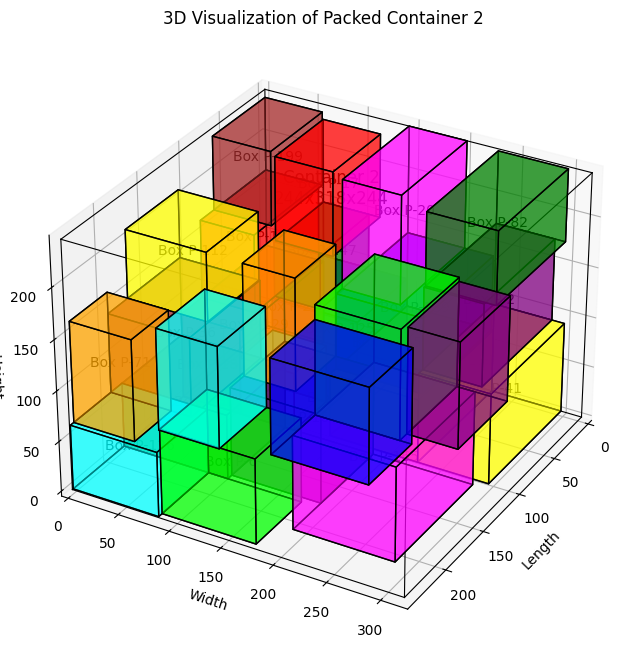

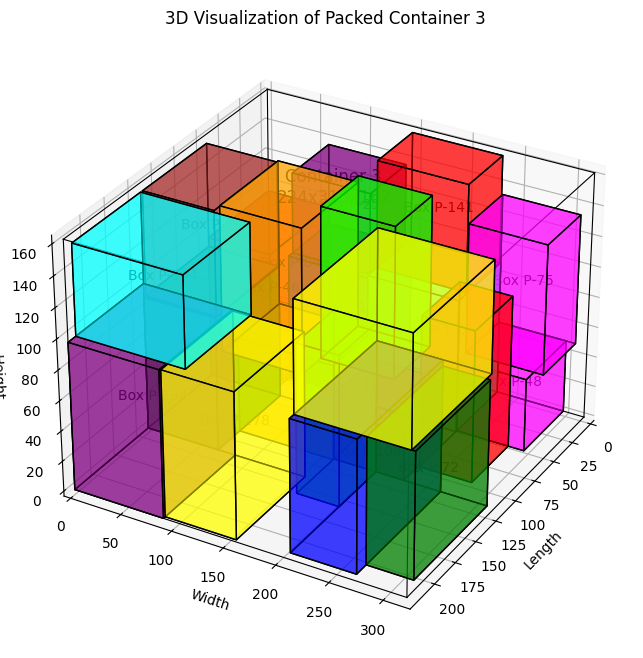

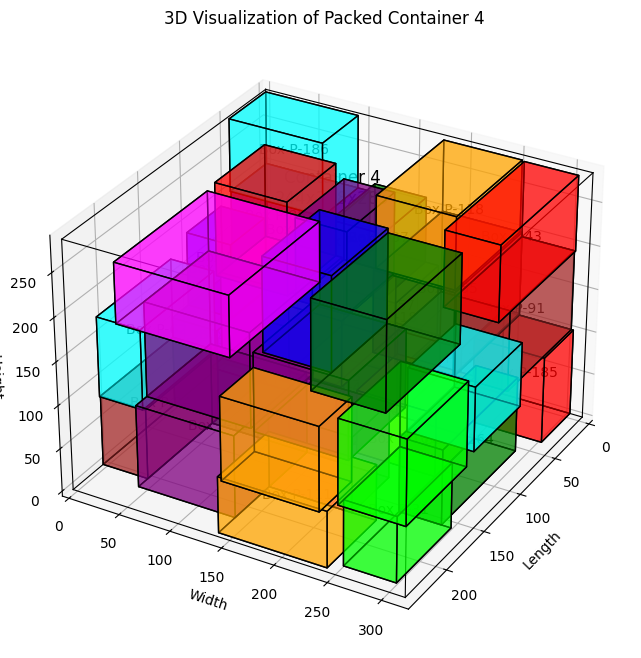

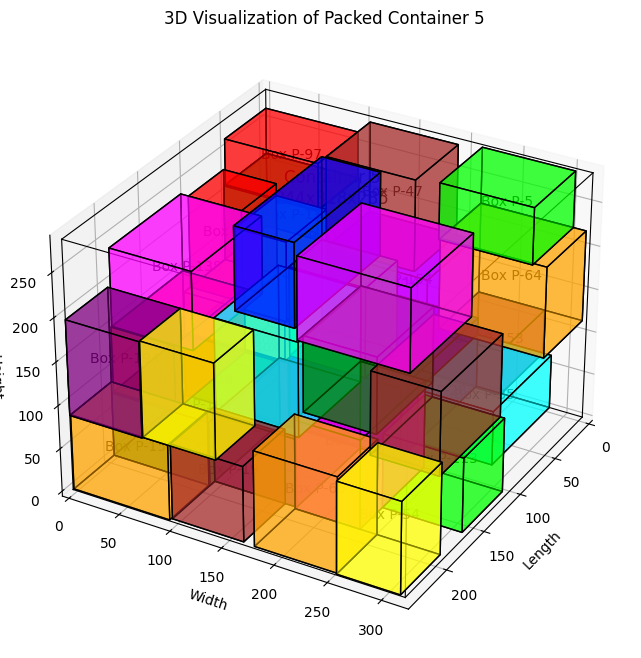

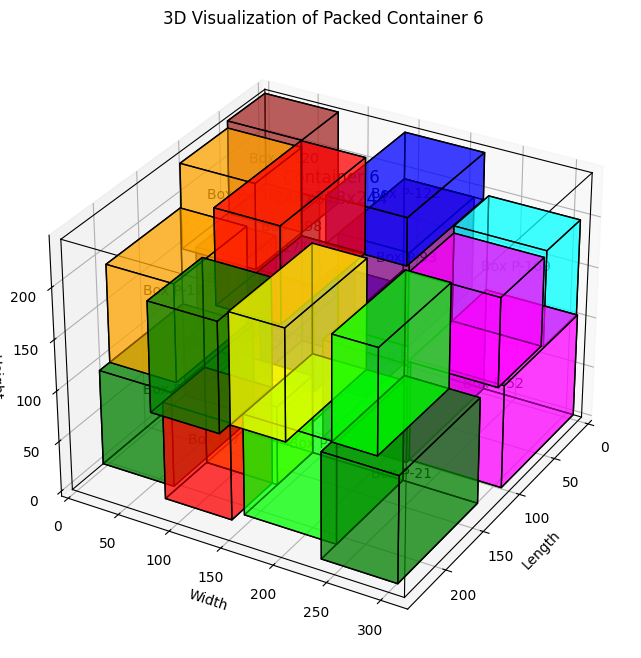

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def visualize_packing_from_multiple_containers(containers):
    for idx, container in enumerate(containers):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection="3d")

        container_corners = [
            (0, 0, 0), (container.length, 0, 0), (container.length, container.width, 0), (0, container.width, 0),
            (0, 0, container.height), (container.length, 0, container.height),
            (container.length, container.width, container.height), (0, container.width, container.height)
        ]

        edges = [
            [0, 1], [1, 2], [2, 3], [3, 0],
            [4, 5], [5, 6], [6, 7], [7, 4],
            [0, 4], [1, 5], [2, 6], [3, 7]
        ]

        for edge in edges:
            p1, p2 = container_corners[edge[0]], container_corners[edge[1]]
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color="black", linewidth=0.8)

        colors = ["red", "blue", "green", "orange", "purple", "cyan", "yellow", "magenta", "brown", "lime"]
        for i, packed in enumerate(container.packed_boxes):
            box = packed["box"]
            pos = packed["position"]
            dims = packed["orientation"]
            x, y, z = pos
            dx, dy, dz = dims

            box_corners = [
                (x, y, z), (x + dx, y, z), (x + dx, y + dy, z), (x, y + dy, z),
                (x, y, z + dz), (x + dx, y, z + dz), (x + dx, y + dy, z + dz), (x, y + dy, z + dz)
            ]

            faces = [
                [box_corners[i] for i in [0, 1, 2, 3]],
                [box_corners[i] for i in [4, 5, 6, 7]],
                [box_corners[i] for i in [0, 1, 5, 4]],
                [box_corners[i] for i in [2, 3, 7, 6]],
                [box_corners[i] for i in [1, 2, 6, 5]],
                [box_corners[i] for i in [0, 3, 7, 4]]
            ]

            ax.add_collection3d(Poly3DCollection(faces, facecolors=colors[i % len(colors)], edgecolor="k", alpha=0.5))

            ax.text(x + dx / 2, y + dy / 2, z + dz / 2, f'Box {box.identifier}', color='black', fontsize=10, ha='center')

        ax.text(container.length / 2, container.width / 2, container.height + 2, f'Container {idx + 1}\n{container.length}x{container.width}x{container.height}', color='black', fontsize=12, ha='center')

        ax.set_xlabel("Length")
        ax.set_ylabel("Width")
        ax.set_zlabel("Height")
        ax.set_xlim(0, container.length)
        ax.set_ylim(0, container.width)
        ax.set_zlim(0, container.height)
        ax.view_init(30, 30)

        plt.title(f"3D Visualization of Packed Container {idx + 1}")
        plt.show()

visualize_packing_from_multiple_containers(best_solution)


In [ ]:
import networkx as nx

def find_dependencies(packed_boxes):
    G = nx.DiGraph()

    for i, box_i in enumerate(packed_boxes):
        for j, box_j in enumerate(packed_boxes):
            if i != j:
                if is_dependency(box_i, box_j):
                    G.add_edge(box_i.box_id, box_j.box_id)

    return G

def is_dependency(box_i, box_j):
    px_i, py_i, pz_i = box_i.position
    length_i, breadth_i, height_i = box_i.orientation
    px_j, py_j, pz_j = box_j.position
    length_j, breadth_j, height_j = box_j.orientation

    bottom_i = pz_i
    top_j = pz_j + height_j

    if bottom_i >= top_j:
        return True

    if (px_i + length_i >= px_j and px_i <= px_j + length_j) and (py_i + breadth_i >= py_j and py_i <= py_j + breadth_j):
        if pz_i + height_i >= pz_j:
            return True

    return False

def topological_sort(G):
    return list(nx.topological_sort(G))

def load_plan(packed_boxes):
    G = find_dependencies(packed_boxes)
    return topological_sort(G)
